In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from torchcox import TorchCox

import numpy as np
import torch
import pandas as pd

# Encoding survival analysis as tensors: Staircase encoding

Consider the synthetic dataset below (the same dataset we used to compute the closed-form solution for validation and unit testing).

In [3]:
valdf = pd.DataFrame({'id':['Bob','Sally','James','Ann'], 'time':[1,3,6,10], 'status':[1,1,0,1], 'smoke':[1,0,0,1]})
valdf

id  time  status  smoke
0    Bob     1       1      1
1  Sally     3       1      0
2  James     6       0      0
3    Ann    10       1      1

In order to encode this data we stacked ordered copies of this matrix, where at each successive slice the top entry corresponds to the event time currently under consideration, and all entries of the slice correspond to all the subjects at risk.

In this dataset we have three unique event times (the times, `time`, where `status`=1, which are {1,3,10}). Which means the first index of the tensor will have three entries (i.e. three slices where each is a matrix), one where Bob, Sally, and Ann are the top entry, respectively.

The other rows in each slice correspond to subjects who were at risk at the time which the top row event ocurred. In this case this means:  
- the first slice will include all subjects with Bob in the top row,  
- the second slice will include all subjects with `time` >=3 (so Sally, James, and Ann) with Sally in the top row,
- the third slice will include only Ann at the top

Note that after the first slice, subjects drop out so padding is required to fill in the bottom rows as entries are shifted up in deeper slices as the event time under consideration increases and the risk set is reduced.

This gives rise to the *staircase* pattern of increasing sparsity of data, shown below. You can see the data getting sparser as the unique event time increases.

In [4]:
tname = 'time'
Xnames = ['smoke']
dname = 'status'


def padToMatch2d(inputtens, targetshape):
    target = torch.zeros(*targetshape)
    target[:inputtens.shape[0], :inputtens.shape[1]] = inputtens
    return target

tensin = torch.from_numpy(valdf[[tname,dname,*Xnames]].values)

        #Get unique event times
tensin_events = torch.unique(tensin[tensin[:,1]==1, 0])

        #For each unique event stack another matrix with event at the top, and all at risk entries below
tensor = torch.stack([padToMatch2d(tensin[tensin[:,0] >= eventtime, :], tensin.shape) for eventtime in tensin_events])

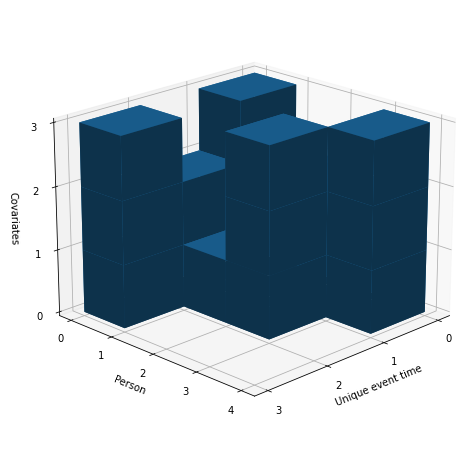

In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=20., azim=45)

ax.set_xlabel('Unique event time')
ax.set_ylabel('Person')
ax.set_zlabel('Covariates')

#Integer tick marks only
#https://stackoverflow.com/questions/12050393/how-to-force-the-y-axis-to-only-use-integers-in-matplotlib#comment110460128_38096332
ax.xaxis.get_major_locator().set_params(integer=True)
ax.yaxis.get_major_locator().set_params(integer=True)
ax.zaxis.get_major_locator().set_params(integer=True)

voxels = (tensor != 0).numpy()

ax.voxels(voxels)

plt.show()

The tensor itself is order 3 and of dimensions:

In [6]:
tensor.shape

torch.Size([3, 4, 3])

That is $n_\text{unique event times} \times n_\text{subjects} \times n_\text{covariates}$

Which in this simple case concretely looks like this:

In [7]:
tensor

tensor([[[ 1.,  1.,  1.],
         [ 3.,  1.,  0.],
         [ 6.,  0.,  0.],
         [10.,  1.,  1.]],

        [[ 3.,  1.,  0.],
         [ 6.,  0.,  0.],
         [10.,  1.,  1.],
         [ 0.,  0.,  0.]],

        [[10.,  1.,  1.],
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.]]])

Here you easily see that the slice `tensor[0,:,:]` corresponds to the columns `[time, status, smoke]` where `Bob` is the top row as the unique event time under consideration here is `time==1`:

In [8]:
tensor[0,:,:]

tensor([[ 1.,  1.,  1.],
        [ 3.,  1.,  0.],
        [ 6.,  0.,  0.],
        [10.,  1.,  1.]])

In [9]:
valdf.loc[valdf.time>=1, ['time','status','smoke']]

time  status  smoke
0     1       1      1
1     3       1      0
2     6       0      0
3    10       1      1

The second unique event time is `time==3` where Bob has had an event (i.e. died) and dropped out of the risk set, so now `Sally` is the top row in this slice and row of padding has been added at the bottom to preserve the fixed tensor dimensionality.

In [10]:
tensor[1,:,:]

tensor([[ 3.,  1.,  0.],
        [ 6.,  0.,  0.],
        [10.,  1.,  1.],
        [ 0.,  0.,  0.]])

In [11]:
valdf.loc[valdf.time>=3, ['time','status','smoke']]

time  status  smoke
1     3       1      0
2     6       0      0
3    10       1      1

And at the last event time, `time==10` only Ann remains

In [12]:
tensor[2,:,:]

tensor([[10.,  1.,  1.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]])

In [13]:
valdf.loc[valdf.time>=10, ['time','status','smoke']]

time  status  smoke
3    10       1      1

Using this _staircase encoding_ of the survival data, along with judicious use of the `torch.einsum()` function and a sensible choice of padding value allows us to very efficiently optimise the negative log Cox likelihood, as we show in `notebooks/How_it_works.ipynb`